# "Anatomy pictures are all you need"


### Import the required libraries

In [109]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from glob import glob
from matplotlib import cm

import albumentations as A

import torch
import torch.nn.functional as F

from lib.data import LABELS
from lib.inference import load_anatomy_stack_from_dicom_paths, upsample_pred_if_needed, \
    rescale_segmented_anatomy_stack_to_isotropy, volumes_from_volume_and_slice_width, \
    get_aortic_diameter_from_volumes_pytorch

PYTORCH_DEVICE = "cuda"   # "cpu" if GPU not available
PIXEL_DIAMETER_MM = 0.64  # This is NOT the pixel diameter of the acquired DICOM (we can get this from the header); this is the pixel size we resampled to when training the network (and therefore will use at inference)
FOV_HEIGHT_PX = 576       # Size in pixels we will crop/pad each slice to; must be a multiple of 32
FOV_WIDTH_PX = 576

### Set the paths to the exported Onnx model and the case we want to analyse

In [110]:
DICOM_STUDY_PATH = r"E:\Dropbox\Exchange\failed_anatomy_092539_21022021_\series0004-Body"
TS_MODEL_PATH = r"E:\Dropbox\Exchange\80_0.80656.pt.ts"

### Create some transforms to ensure the slice is the correct size

In [111]:
inference_transform = A.Compose([
    A.PadIfNeeded(min_height=FOV_HEIGHT_PX, min_width=FOV_WIDTH_PX, border_mode=cv2.BORDER_CONSTANT, value=0),
    A.CenterCrop(height=FOV_HEIGHT_PX, width=FOV_WIDTH_PX)
])

### Load our network

In [112]:
model = torch.jit.load(TS_MODEL_PATH).to(PYTORCH_DEVICE)

### Load the study, transform the slices to the correct pixel-size and segment the stack

In [113]:
dicom_files = sorted(glob(os.path.join(DICOM_STUDY_PATH, "*.dcm")))

anatomy_stack, _, slice_thickness = load_anatomy_stack_from_dicom_paths(dicom_files,
                                                                        inference_transform,
                                                                        rescale_to_pixel_size_mm=PIXEL_DIAMETER_MM)


In [114]:
with torch.no_grad():
    anatomy_stack_pred = model(torch.tensor(anatomy_stack).float().to(PYTORCH_DEVICE))


### Covnert our segmented predictions into an isotropic 3D model

In [115]:
with torch.no_grad():
    anatomy_stack_pred = torch.tensor(anatomy_stack_pred).to(PYTORCH_DEVICE).float()

    # Some networks produce smaller predictions per slice, e.g. HRNet - upsample the slices if needed
    anatomy_stack_pred = upsample_pred_if_needed(anatomy_stack_pred, anatomy_stack)

    # Now make pixels isotropic
    anatomy_stack_pred = rescale_segmented_anatomy_stack_to_isotropy(anatomy_stack_pred, slice_thickness)

    z_expansion = anatomy_stack_pred.shape[1] / anatomy_stack.shape[0]  # Will be used to align MRI with segments

    # Move back to numpy for the argmax or we end up using 20 Gb of GPU RAM just for inference
    anatomy_3d = np.argmax(anatomy_stack_pred.cpu().numpy(), axis=0)

<ipython-input-115-d5d6819478f3>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anatomy_stack_pred = torch.tensor(anatomy_stack_pred).to(PYTORCH_DEVICE).float()


### Perform our calculations based on the 3D model

In [116]:
# Calculations
volumes_ml, volumes_px = volumes_from_volume_and_slice_width(anatomy_3d, PIXEL_DIAMETER_MM)
aorta_diam_mm = get_aortic_diameter_from_volumes_pytorch(anatomy_3d)

### Create a report

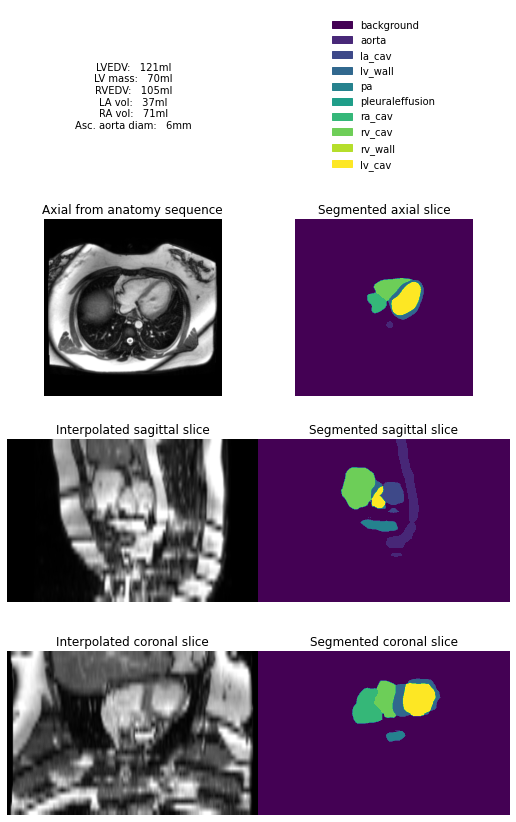

In [117]:
# Create an isotropic DICOM for visualisation purposes (not needed for inference)
with torch.no_grad():
    anatomy_stack_iso = F.interpolate(torch.tensor(anatomy_stack).to(PYTORCH_DEVICE).transpose(0, 1).unsqueeze(0),
                                      size=anatomy_3d.shape,
                                      mode='trilinear',
                                      align_corners=False).cpu().numpy()[0,0]

# Permute both to x, y, z
anatomy_stack_iso = anatomy_stack_iso.transpose((1,2,0))
anatomy_3d = anatomy_3d.transpose((1,2,0))

fig, axes = plt.subplots(4, 2, figsize=(9, 15))
fig.subplots_adjust(hspace=0.2, wspace=0)
for r in axes:
    for ax in r:
        ax.axis('off')

# Report
axes[0,0].imshow(np.ones((100,100,3)))
axes[0,0].text(50, 50,
               f"LVEDV:   {round(volumes_ml['lv_cav'])}ml\n"
               f"LV mass:   {round(volumes_ml['lv_wall'])}ml\n"
               f"RVEDV:   {round(volumes_ml['rv_cav'])}ml\n"
               f"LA vol:   {round(volumes_ml['la_cav'])}ml\n"
               f"RA vol:   {round(volumes_ml['ra_cav'])}ml\n"
               f"Asc. aorta diam:   {round(aorta_diam_mm)}mm",
               horizontalalignment='center', verticalalignment='center')

# Create legend
cmap = cm.get_cmap('viridis', len(LABELS))
legend_patches = []
for i_label, label in enumerate(LABELS):
    legend_patches.append(mpatches.Patch(color=cmap(i_label/len(LABELS)), label=label))

slice_x, slice_y, slize_z = 250, 300, 280

axes[0,1].imshow(np.ones((100,100,3)))
axes[0,1].legend(handles=legend_patches, loc=10, frameon=False)

# Axial slice
axes[1,0].set_title("Axial from anatomy sequence")
axes[1,0].imshow(anatomy_stack_iso[:, :, slize_z], cmap='gray')
axes[1,1].set_title("Segmented axial slice")
axes[1,1].imshow(anatomy_3d[:, :, slize_z], cmap=cmap)

# Sagittal slice
axes[2,0].set_title("Interpolated sagittal slice")
axes[2,0].imshow(np.rot90(anatomy_stack_iso[:, slice_y, :]), cmap='gray')
axes[2,1].set_title("Segmented sagittal slice")
axes[2,1].imshow(np.rot90(anatomy_3d[:, slice_y, :]), cmap=cmap)

# Coronal slice
axes[3,0].set_title("Interpolated coronal slice")
axes[3,0].imshow(np.rot90(anatomy_stack_iso[slice_x, :, :]), cmap='gray')
axes[3,1].set_title("Segmented coronal slice")
axes[3,1].imshow(np.rot90(anatomy_3d[slice_x, :, :]), cmap=cmap)

plt.show()